# Facial Expression Recognition

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os

from tensorflow import keras
from keras import Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Add, BatchNormalization, Activation, Dropout, PReLU
from keras.regularizers import l1, l2, l1_l2
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [3]:
df = {}
for expression in os.listdir("train/"):
    directory = "train/" + expression
    df[expression] = len(os.listdir(directory))
df = pd.DataFrame(df, index=[0])

In [4]:
img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory("train/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

test_generator = test_datagen.flow_from_directory("test/", target_size = (img_size, img_size),
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             class_mode = 'categorical',
                                             shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Building Block for res-Net
def convolution_block(feed, f1, f2, f):
    shortcut =  feed
    
    # For the convolutional part
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", activation = 'relu', kernel_regularizer=l2(1e-4))(feed)
    mix = Conv2D(filters = f1, kernel_size=(3,3), padding = "Same", kernel_regularizer=l2(1e-4))(mix)

    # For the shortcut path
    # X_shortcut = Conv2D(filters = f1, kernel_size=(1,1), padding = "Same",kernel_regularizer=l2(1e-4))(X_shortcut)

    mix = Add()([shortcut,mix])
    mix = PReLU(alpha_initializer='zeros')(mix)

    mix = Conv2D(filters = f2, activation = 'relu', kernel_size=(f,f), padding = "Valid", kernel_regularizer=l2(1e-4))(mix)
    
    return mix

# Deep Convolution Neural Network

In [10]:
model2 = Sequential()

model2.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(48,48,1))) # Output is 46*46*16
model2.add(Conv2D(32,kernel_size=(3,3),activation='relu')) # Output is 44*44*32
model2.add(MaxPooling2D((2,2), strides=2)) # Output is 22*22*32
model2.add(BatchNormalization())

model2.add(Conv2D(64,kernel_size=(3,3),activation='relu')) # Output is 20*20*64
model2.add(MaxPooling2D((2,2), strides=2)) # Output is 10*10*64
model2.add(BatchNormalization())

model2.add(Conv2D(128,kernel_size=(3,3),activation='relu')) # Output is 10*10*128
model2.add(MaxPooling2D((2,2),strides=2)) # Output is 4*4*128
model2.add(BatchNormalization())

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())

model2.add(Dense(7, activation='softmax'))

In [11]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 22, 22, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 10, 64)       

In [12]:
model2.compile(loss="categorical_crossentropy", optimizer=optimizer , metrics=["accuracy"])
history2 = model2.fit(train_generator,shuffle=True, batch_size=batch_size, epochs=50, validation_data=test_generator, validation_steps=113)

Epoch 1/50
449/449 [==============================] - 91s 202ms/step - loss: 1.7589 - accuracy: 0.2995 - val_loss: 1.9246 - val_accuracy: 0.2307
Epoch 2/50
449/449 [==============================] - 96s 214ms/step - loss: 1.4616 - accuracy: 0.4295 - val_loss: 1.6826 - val_accuracy: 0.3564
Epoch 3/50
449/449 [==============================] - 98s 219ms/step - loss: 1.3621 - accuracy: 0.4748 - val_loss: 1.7889 - val_accuracy: 0.3089
Epoch 4/50
449/449 [==============================] - 99s 220ms/step - loss: 1.3174 - accuracy: 0.4948 - val_loss: 1.8611 - val_accuracy: 0.3582
Epoch 5/50
449/449 [==============================] - 98s 218ms/step - loss: 1.2876 - accuracy: 0.5097 - val_loss: 1.3377 - val_accuracy: 0.4831
Epoch 6/50
449/449 [==============================] - 97s 217ms/step - loss: 1.2633 - accuracy: 0.5201 - val_loss: 1.2379 - val_accuracy: 0.5217
Epoch 7/50
449/449 [==============================] - 98s 218ms/step - loss: 1.2395 - accuracy: 0.5274 - val_loss: 1.4811 - val_ac

In [14]:
score2 = model2.evaluate(test_generator, verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 1.0383667945861816
Test accuracy: 0.6103371381759644


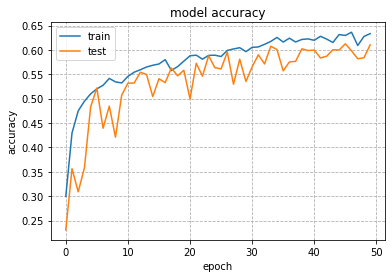

In [15]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper left')
plt.show()

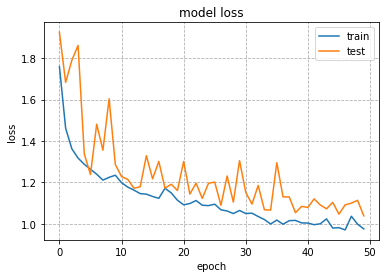

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(linestyle="--")
plt.legend(['train', 'test'], loc='upper right')
plt.show()